In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize as NormColor
from tqdm.notebook import tqdm
sys.path.append(".")
import HOD
from astropy.cosmology import Planck15 as cosmo
h = cosmo.H(0).value/100
sigma_logM, alpha = 0.2, 1.0

plt.rcParams['figure.figsize'  ] = (3.3,2.0)
plt.rcParams['font.size'       ] = 16
plt.rcParams['axes.labelsize'  ] = 14
plt.rcParams['legend.fontsize' ] = 13
plt.rcParams['legend.frameon'  ] = False
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['font.family'     ] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction' ] = 'in'
plt.rcParams['ytick.direction' ] = 'in'
plt.rcParams['xtick.top'       ] = True
plt.rcParams['ytick.right'     ] = True
plt.rcParams['xtick.labelsize' ] = 16
plt.rcParams['ytick.labelsize' ] = 16
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1.25
plt.rcParams['xtick.minor.width'] = 0.75
plt.rcParams['ytick.major.width'] = 1.25
plt.rcParams['ytick.minor.width'] = 0.75

In [2]:
def schechter_LF(M_int,zs):
    '''
    Returns the Schechter UV galaxy Luminosity Function.
    Parameters are taken from Bouwens et al. 2022
    link: (https://ui.adsabs.harvard.edu/abs/2022ApJ...940...55B/abstract)

            Parameters:
                    M_int: ndarray(dtype=float, ndim=1)
                        Absolute magnitude (mag)
                    zs: (float)
                        Redshift of the galaxy population
            Returns:
                    LF: ndarray(dtype=float, ndim=1)
                        Schechter UV LF
    '''
    zt = 2.42
    phi_0 = 0.38*10**(-3.)*np.power(10,(-0.35*(zs-6)+(-0.027)*(zs-6)**2))
    alpha = -1.95 + (-0.11) * (zs - 6)
    if zs < zt:
        Mstar = -20.87+(-1.1*(zs-zt))
    else:
        Mstar = -21.04+(-0.05*(zs-6))
    nrmlzt = phi_0 * (np.log(10) / 2.5)
    pwrlaw = np.power(10, 0.4 * (Mstar - M_int) * (alpha + 1))
    expctf = np.exp(-1 * np.power(10, 0.4 * (Mstar - M_int)))
    return nrmlzt * pwrlaw * expctf

def get_wavelength_nm_from_photo_band(photo_band):
    '''
    Returns the wavelength and FWHM in nanometers for a given band.

            Parameters:
                    photo_band: (string)
                        Observing band (see supported photo bands)
            Returns:
                    wav_nm: (float)
                        wavelength (nanometers)
                    FWHM_nm: (float)
                        FWHM (nanometers)
    '''
    wav_nm, FWHM = 0, 0
    if   photo_band == 'galex_FUV':
        wav_nm, FWHM = 150, 30
    elif photo_band == 'galex_NUV':
        wav_nm, FWHM = 230, 50
    elif photo_band == 'sdss_g0':
        wav_nm, FWHM = 475, 128
    elif photo_band == 'sdss_r0':
        wav_nm, FWHM = 622, 138
    elif photo_band == 'sdss_i0':
        wav_nm, FWHM = 763, 149
    elif photo_band == 'sdss_z0':
        wav_nm, FWHM = 905, 152
    elif photo_band == 'ukirt_wfcam_Y':
        wav_nm, FWHM = 1031, 120
    elif photo_band == 'ukirt_wfcam_J':
        wav_nm, FWHM = 1241, 213
    elif photo_band == 'ukirt_wfcam_H':
        wav_nm, FWHM = 1631, 307
    elif photo_band == 'ukirt_wfcam_K':
        wav_nm, FWHM = 2201, 390
    return wav_nm, FWHM

def get_UV_cont_slope(zs, intrinsic_Mag_UV):
    '''
    Returns the interpolation for the evolution with redshift of the UV Continuum Slope and its
    derivative with magnitude.
    For 0 < z < 4 Use linear interpolation from Fig.6 of Mondal et al. 2023
    link: https://iopscience.iop.org/article/10.3847/1538-4357/acc110/pdf
    For 4 < z < 6 Table 4 from Bouwens et al. 2014
    link: https://iopscience.iop.org/article/10.1088/0004-637X/793/2/115/pdf
    For 6 < z < 8 Table 3 from Bouwens et al. 2014
    link: https://iopscience.iop.org/article/10.1088/0004-637X/793/2/115/pdf
    For 8 < z < 10 from Eq.16 in Liu et al. 2016 (Dragons paper IV)
    link: https://ui.adsabs.harvard.edu/abs/2016MNRAS.462..235L/abstract

            Parameters:
                    zs: (float)
                        Redshift of the source
                    intrinsic_Mag_UV: (float)
                        Intrinsic UV Magnitude of the source
            Returns:
                    beta: (float)
                        UV Continuum Slope
    '''
    B, dBdM, M_beta = -2.16, -0.16, -18.8
    if np.around(zs,0) < 4:
        B, dBdM, M_beta = -1.5+(zs-1)*((1.5-2.21)/6), 0, -18.8
    elif np.around(zs,0)==4:
        B, dBdM, M_beta = -1.95, -0.13, -18.8
        dBdM = dBdM if intrinsic_Mag_UV <= M_beta else -0.08
    elif np.around(zs,0)==5:
        B, dBdM, M_beta = -2.05, -0.17, -18.8
        dBdM = dBdM if intrinsic_Mag_UV <= M_beta else -0.08
    elif np.around(zs,0)==6:
        B, dBdM, M_beta = -2.22, -0.24, -18.8
        dBdM = dBdM if intrinsic_Mag_UV <= M_beta else -0.08
    elif np.around(zs,0)==7:
        B, dBdM, M_beta = -2.05, -0.20, -19.5
    elif np.around(zs,0)==8:
        B, dBdM, M_beta = -2.13, -0.15, -19.5
    elif np.around(zs,0)==9:
        B, dBdM, M_beta = -2.19, -0.16, -19.5
    elif np.around(zs,0)==10:
        B, dBdM, M_beta = -2.16, -0.16, -19.5
    return dBdM * (intrinsic_Mag_UV - M_beta) + B

def Flux_integral_div_C(UV_slope, avg_wave, FWHM_wave):
    '''
    Returns the Integrated Flux over a rectangular window with mean avg_wave and width FWHM_wave.

            Parameters:
                    beta: (float)
                        UV Continuum Slope
                    avg_wave: (float)
                        Window mean
                    FWHM_wave: (float)
                        Window width
            Returns:
                    FluxI: (float)
                        Flux integrated over a rectangular window
    '''
    return ((avg_wave+FWHM_wave/2)**(UV_slope+1)-(avg_wave-FWHM_wave/2)**(UV_slope+1))/(UV_slope+1)

def K_corr_singleMag(zs, observing_band, restframe_band, M):
    '''
    Returns the K correction for a source with magnitude M at redshift z,
    with the intrinsic magnitude calculated in the restframe_band and observed in the
    observing_band.

            Parameters:
                    zs: (float)
                        Redshift of the source
                    observing_band: (string)
                        Observing band (see supported photo bands)
                    restframe_band: (string)
                        Restframe band (see supported photo bands)
                    M: (float)
                        Intrinsic Magnitude
            Returns:
                    Kcorr: (float)
                        K correction
    '''
    supported_K_correctn_photo_bands = [
        'galex_FUV', 'galex_NUV',
        'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0',
        'ukirt_wfcam_Y', 'ukirt_wfcam_J', 'ukirt_wfcam_H', 'ukirt_wfcam_K']
    if all(x in supported_K_correctn_photo_bands for x in [observing_band, restframe_band]):
        rest_frame_wave, rest_frame_FWHM = get_wavelength_nm_from_photo_band(restframe_band)
        obsr_frame_wave, obsr_frame_FWHM = get_wavelength_nm_from_photo_band(observing_band)
        UV_slope = get_UV_cont_slope(zs, M)+1
        rest_frame_flux = Flux_integral_div_C(UV_slope, rest_frame_wave, rest_frame_FWHM)
        obsr_frame_flux = Flux_integral_div_C(UV_slope, obsr_frame_wave, obsr_frame_FWHM)/(1 + zs)
        return -2.5 * np.log10(obsr_frame_flux / rest_frame_flux)
    return 0

def K_correction(zs, observing_band, restframe_band, intrinsic_Mag):
    '''
    Returns the K correction for a population of sources with magnitude M at redshift z,
    with the intrinsic magnitude calculated in the restframe_band and observed in the
    observing_band.

            Parameters:
                    zs: (float)
                        Redshift of the source
                    observing_band: (string)
                        Observing band (see supported photo bands)
                    restframe_band: (string)
                        Restframe band (see supported photo bands)
                    M: ndarray(dtype=float, ndim=1)
                        Intrinsic Magnitudes
            Returns:
                    Kcorr: (float)
                        K correction
    '''
    if hasattr(intrinsic_Mag, '__len__'):
        res = [K_corr_singleMag(zs, observing_band, restframe_band, M) for M in intrinsic_Mag]
    else:
        res = K_corr_singleMag(zs, observing_band, restframe_band, intrinsic_Mag)
    return np.asarray(res)

def calc_apparent_magnitude(z, M_array_UV, obs_band = 'ukirt_wfcam_Y'):
    corr = 5 * np.log10(cosmo.luminosity_distance(z).value * 1e5) +\
          K_correction(z, obs_band, 'galex_FUV', M_array_UV)
    return M_array_UV + corr


In [4]:
def get_z_and_N_array(z, m, VERBOSE = False):
    PATH = 'Harikane_z_distribution/'
    z1s, z2s = str(int(z//1)), str(int(np.around(10*(z - z//1), 0)))
    m1s, m2s = str(int(m//1)), str(int(100*(m - m//1))) if (m - m//1) != 0 else '00'
    filename = 'z_'+z1s+'.'+z2s+'_m_'+m1s+'.'+m2s+'.data'
    try:
        f = np.loadtxt(PATH+filename, delimiter=' ')
        z_array, N_z_nrm = f.T[0], f.T[1]
        if 1: N_z_nrm = N_z_nrm/np.trapz(N_z_nrm, z_array)
    except:
        if VERBOSE:
            print('Do not have that z and m combination in the database')
            print(PATH+filename)
        return None, None
    return z_array, N_z_nrm

def get_avg_Harikane(M_min, sigma_logM, M_sat, alpha, z, z_array, N_z_nrm,
                     n_g = None, AVG_OVER_Z = False,
                     _A_ = 0, _B_ = np.inf):
    if AVG_OVER_Z:
        a, b, c, d = np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)
        for z in z_array:
            M_h_array, HMF_array, nu_array, _, __ = HOD.init_lookup_table(z, LOW_RES=True)
            a = np.append(a, HOD.get_AVG_Host_Halo_Mass(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array,
                                                        n_g=n_g, int_M_min=_A_, int_M_max=_B_))
            b = np.append(b, HOD.get_EFF_gal_bias(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, nu_array,
                                                  n_g=n_g, int_M_min=_A_, int_M_max=_B_))
            c = np.append(c, HOD.get_AVG_f_sat(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array,
                                               n_g=n_g, int_M_min=_A_, int_M_max=_B_))
            d = np.append(d, HOD.get_N_dens_avg(z_array, M_min, sigma_logM, M_sat, alpha, N_z_nrm,
                                                int_M_min=_A_, int_M_max=_B_))
        return np.log10(np.sum(a * N_z_nrm * np.diff(z_array)[0])),\
               np.sum(b * N_z_nrm * np.diff(z_array)[0]),\
               np.log10(np.sum(c * N_z_nrm * np.diff(z_array)[0])),\
               np.log10(np.sum(d * N_z_nrm * np.diff(z_array)[0]))
    M_h_array, HMF_array, nu_array, _, __ = HOD.init_lookup_table(z, LOW_RES=True)
    return np.log10(HOD.get_AVG_Host_Halo_Mass(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, n_g=n_g, int_M_min=_A_, int_M_max=_B_)),\
            HOD.get_EFF_gal_bias(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, nu_array, n_g=n_g, int_M_min=_A_, int_M_max=_B_),\
            np.log10(HOD.get_AVG_f_sat(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, n_g=n_g, int_M_min=_A_, int_M_max=_B_)),\
            HOD.get_N_dens_avg(z_array, M_min, sigma_logM, M_sat, alpha, N_z_nrm, int_M_min=_A_, int_M_max=_B_)

def get_summary(z, m, M_min, M_sat, VERBOSE = False, sigma_logM = 0.2, alpha = 1, _A_ = 0, _B_ = np.inf):
    z_array, N_z_nrm = get_z_and_N_array(z, m, VERBOSE)
    if z_array is not None:
        n_g = HOD.get_N_dens_avg(z_array, M_min, sigma_logM, M_sat, alpha, N_z_nrm)
        logMh, beff, logfsat, n_g = get_avg_Harikane(M_min, sigma_logM, M_sat, alpha, z, z_array, N_z_nrm,
                                                     n_g = n_g, AVG_OVER_Z = False , _A_ = _A_, _B_ = _B_)
        if VERBOSE:
            print('Redshift: ', z)
            print('  ', 'M_min', 'M_sat')
            print('  ', np.log10(M_min), np.log10(M_sat))
            print('  ', 'logMh  ', 'beff ', 'logfsat', '  n_g')
            print(f'   {logMh:.2f} | {beff:.2f} | {logfsat:.2f} | {n_g:.2f}')
        return logMh, beff, logfsat, n_g
    return None, None, None, None

def plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g, _A_ = 0, _B_ = np.inf):
    fig, ax = plt.subplots(2,4, figsize=(16,4), sharex=True)
    m_array, i = np.arange(23.5, 27, 0.5), 0
    _col_ = iter(cm.viridis(np.linspace(0, 1, len(m_array))))
    for m in m_array:
        z_array, N_z_nrm = get_z_and_N_array(z, m, VERBOSE = False)
        _c_ = next(_col_)
        if z_array is not None:
            logMh, beff, logfsat, n_g = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                    M_sat_array[i], alpha,
                                                    z, z_array, N_z_nrm, AVG_OVER_Z = False , _A_ = _A_, _B_ = _B_)
            ax[0, 0].scatter(m, logMh, c= _c_)
            ax[0, 1].scatter(m, beff, c= _c_)
            ax[0, 2].scatter(m, logfsat, c= _c_)
            ax[0, 3].scatter(m, n_g, c= _c_)
            ax[0, 0].scatter(m, H_log_avg_Mh[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 1].scatter(m, H_beff[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 2].scatter(m, H_log_fsat[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 3].scatter(m, H_n_g[i], edgecolors= _c_, marker = 'D', facecolors='none')
            if 0 :
                logMh, beff, logfsat, n_g = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                        M_sat_array[i], alpha,
                                                        z, z_array, N_z_nrm,
                                                        AVG_OVER_Z = True)
                ax[0, 0].scatter(m, logMh, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 1].scatter(m, beff, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 2].scatter(m, logfsat, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 3].scatter(m, n_g, edgecolors= _c_, marker = 'o', facecolors='none')
            ax[1, 0].scatter(m, np.power(10, H_log_avg_Mh[i])/np.power(10, logMh), c= _c_)
            ax[1, 1].scatter(m, H_beff[i]/beff, c= _c_)
            ax[1, 2].scatter(m, np.power(10, H_log_fsat[i])/np.power(10, logfsat), c= _c_)
            ax[1, 3].scatter(m, H_n_g[i]/n_g, c= _c_)
            ax[1, 0].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 1].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 2].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 3].axhline(1, ls='--', c = 'k', alpha = 0.5)
            i += 1
    ax[0, 0].set_title(r'$\log(M_h)$')
    ax[0, 1].set_title(r'$b_{eff}$')
    ax[0, 2].set_title(r'$\log(f_{sat})$')
    ax[0, 3].set_title(r'$n_{g}$')
    ax[1, 0].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 1].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 2].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 3].set_xlabel(r'$m^{th}_{UV}$')
    ax[0, 0].set_ylabel(f'z = {z}')
    ax[1, 0].set_ylabel(f'Ratio Harik/Me')
    ax[1, 0].set_ylim((0.5, 1.5))
    ax[1, 1].set_ylim((0.8, 1.2))
    ax[1, 2].set_ylim((0, 2))
    ax[1, 3].set_ylim((0, 2))
    plt.show()

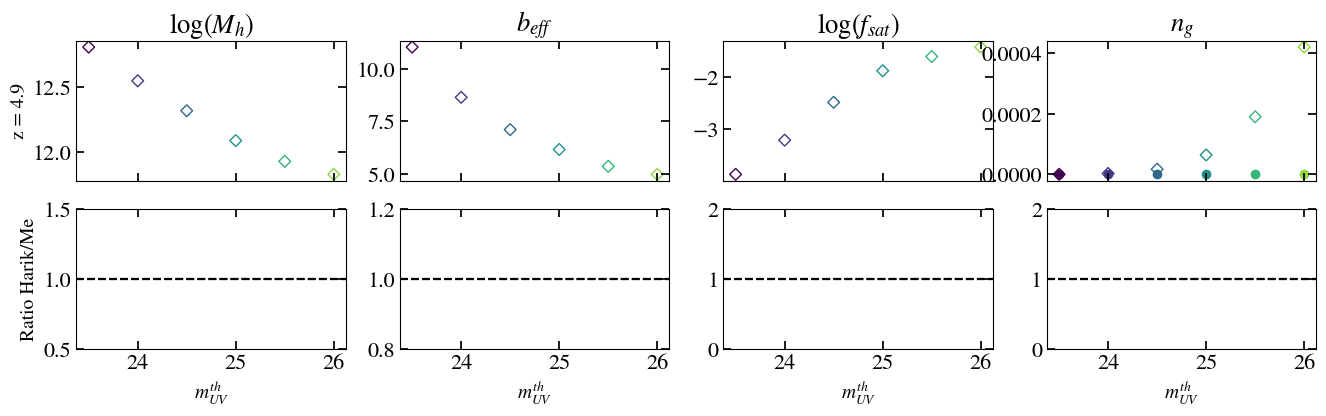

In [5]:
z= 4.9
log_M_min = np.array([12.95, 12.60, 12.29, 12.00, 11.76, 11.57])
log_M_sat = np.array([16.65, 15.70, 14.63, 13.45, 12.57, 11.86])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.81, 12.55, 12.32, 12.09, 11.93, 11.83])
H_beff       = np.array([11.02,  8.64,   7.11,  6.17,  5.37, 4.99])
H_log_fsat   = np.array([-3.86, -3.21, -2.49, -1.89, -1.62, -1.44])
H_n_g        = np.array([2.2e-7, 2.9e-6, 1.7e-5, 6.4e-5, 1.9e-4, 4.2e-4])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g, _A_ = 11.15, _B_ = 12.34)

In [6]:
z = 1.7
m = 24.5
z_array, N_z_nrm = get_z_and_N_array(z, m, VERBOSE = False)
print(get_avg_Harikane(np.power(10, 12.46), sigma_logM,
                 np.power(10, 14.18), alpha,
                 z, z_array, N_z_nrm,
                 AVG_OVER_Z = True,
                 _A_ = 0, _B_ = np.inf))
print(get_avg_Harikane(np.power(10, 12.46), sigma_logM,
                 np.power(10, 14.18), alpha,
                 z, z_array, N_z_nrm,
                 AVG_OVER_Z = True,
                 _A_ = 1e10, _B_ = np.inf))
print(get_avg_Harikane(np.power(10, 12.46), sigma_logM,
                 np.power(10, 14.18), alpha,
                 z, z_array, N_z_nrm,
                 AVG_OVER_Z = True,
                 _A_ = 1e13, _B_ = np.inf))
print(get_avg_Harikane(np.power(10, 12.46), sigma_logM,
                 np.power(10, 14.18), alpha,
                 z, z_array, N_z_nrm,
                 AVG_OVER_Z = True,
                 _A_ = 1e15, _B_ = np.inf))

(12.81094236983408, 2.5990856142117, -1.4139380125502514, -3.4240030947809235)
(12.81094236983408, 2.5990856142117, -1.4139380125502514, -3.4240030947809235)
(13.335287296378375, 3.9613103278562942, -0.9281618690394077, -4.294890093107267)
(15.067231370673865, 26.457379718480983, -0.05347632633225679, -10.436982984464494)


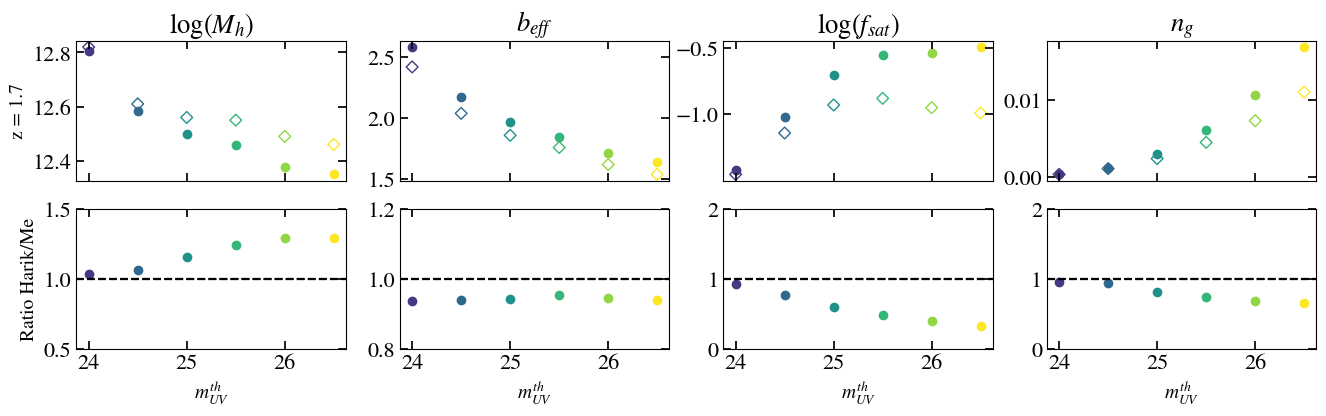

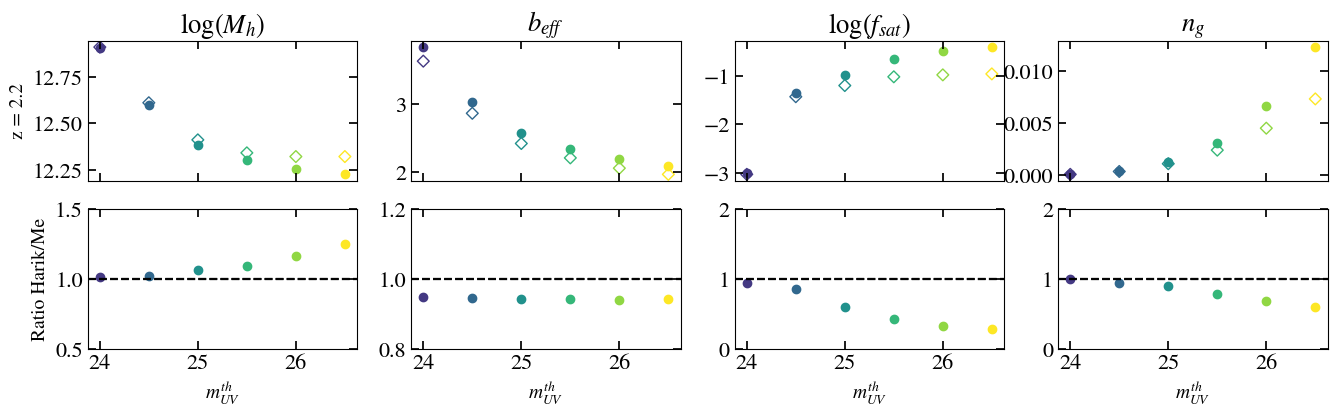

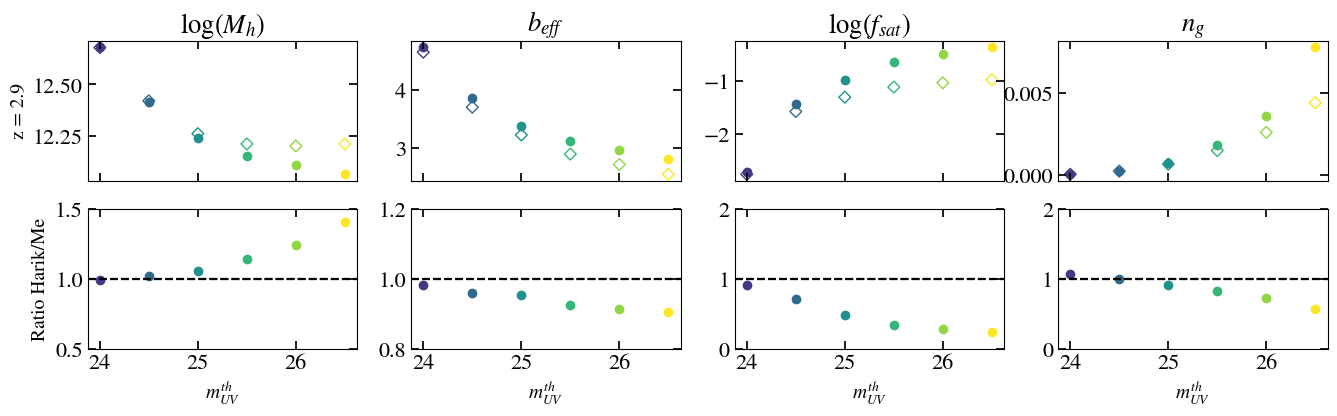

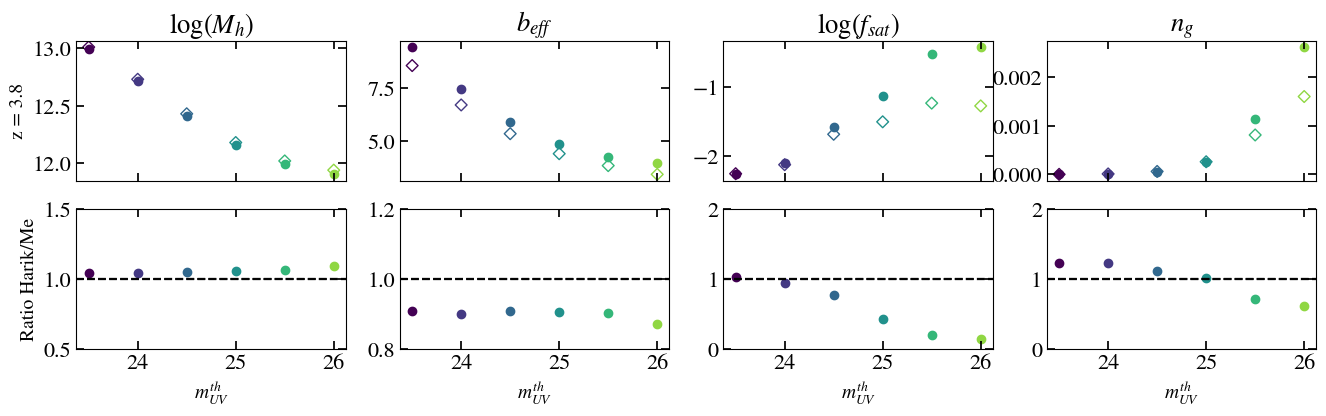

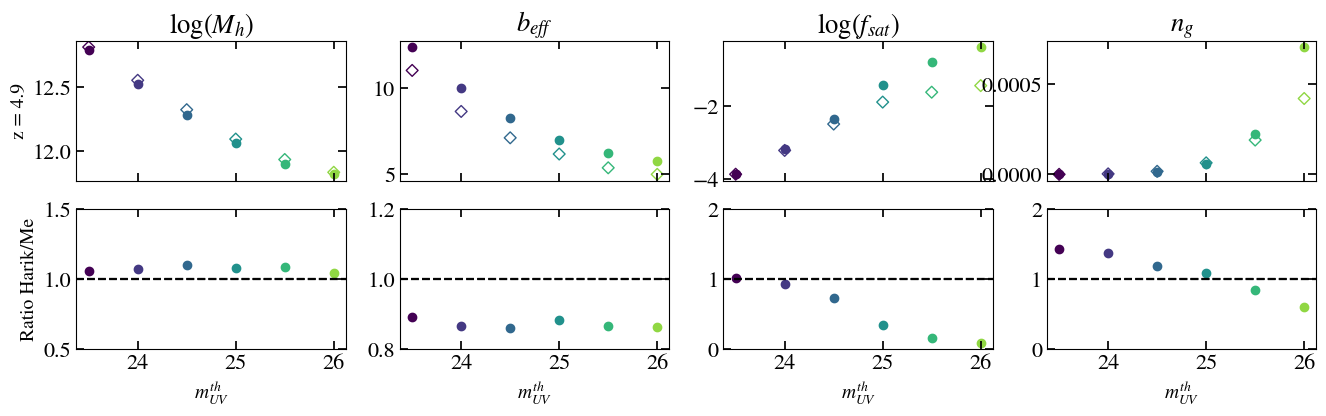

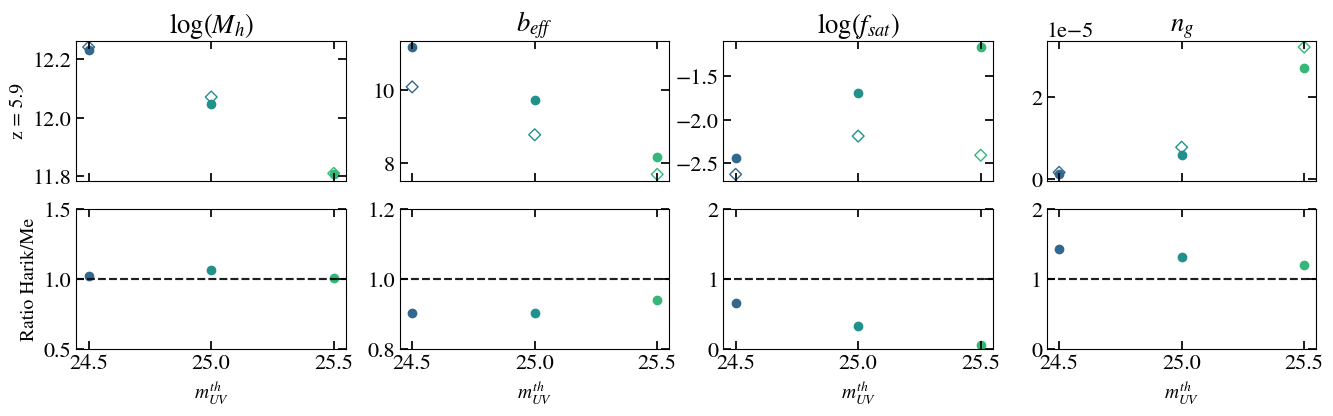

In [7]:
z= 1.7
log_M_min = np.array([12.46, 12.09, 11.79, 11.55, 11.33, 11.16])
log_M_sat = np.array([14.18, 13.47, 12.86, 12.48, 12.28, 12.08])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.82, 12.61, 12.56, 12.55, 12.49, 12.46])
H_beff       = np.array([2.42,   2.04,  1.86,  1.76,  1.62,  1.54])
H_log_fsat   = np.array([-1.45, -1.14, -0.93, -0.88, -0.95, -0.99])
H_n_g        = np.array([3.6e-4, 1.1e-3, 2.4e-3, 4.5e-3, 7.3e-3, 1.1e-2])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g)

z= 2.2
log_M_min = np.array([12.72, 12.30, 11.95, 11.68, 11.45, 11.26])
log_M_sat = np.array([15.91, 13.92, 13.23, 12.62, 12.23, 11.94])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.91, 12.61, 12.41, 12.34, 12.32, 12.32])
H_beff       = np.array([3.62,  2.86,   2.42,  2.21,  2.06,  1.97])
H_log_fsat   = np.array([-3.03, -1.43, -1.20, -1.02, -0.98, -0.96])
H_n_g        = np.array([8.4e-5, 3.6e-4, 1.1e-3, 2.4e-3, 4.5e-3, 7.3e-3])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g)

z= 2.9
log_M_min = np.array([12.55, 12.19, 11.92, 11.71, 11.55, 11.36])
log_M_sat = np.array([15.39, 13.80, 13.12, 12.55, 12.20, 11.84])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.68, 12.42, 12.26, 12.21, 12.20, 12.21])
H_beff       = np.array([4.66,  3.71,   3.23,  2.90,  2.72,  2.55])
H_log_fsat   = np.array([-2.75, -1.57, -1.30, -1.11, -1.03, -0.97])
H_n_g        = np.array([5.7e-5, 2.5e-4, 6.7e-4, 1.5e-3, 2.6e-3, 4.4e-3])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g)

z= 3.8
log_M_min = np.array([13.08, 12.71, 12.32, 11.98, 11.66, 11.48])
log_M_sat = np.array([15.25, 14.80, 13.96, 13.23, 12.24, 11.94])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([13.01, 12.73, 12.43, 12.18, 12.02, 11.94])
H_beff       = np.array([8.55,  6.70,   5.35,  4.41,  3.85,  3.44])
H_log_fsat   = np.array([-2.25, -2.12, -1.68, -1.50, -1.23, -1.27])
H_n_g        = np.array([1.1e-6, 1.0e-5, 6.1e-5, 2.6e-4, 8.1e-4, 1.6e-3])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g)

z= 4.9
log_M_min = np.array([12.95, 12.60, 12.29, 12.00, 11.76, 11.57])
log_M_sat = np.array([16.65, 15.70, 14.63, 13.45, 12.57, 11.86])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.81, 12.55, 12.32, 12.09, 11.93, 11.83])
H_beff       = np.array([11.02,  8.64,   7.11,  6.17,  5.37, 4.99])
H_log_fsat   = np.array([-3.86, -3.21, -2.49, -1.89, -1.62, -1.44])
H_n_g        = np.array([2.2e-7, 2.9e-6, 1.7e-5, 6.4e-5, 1.9e-4, 4.2e-4])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g)

z= 5.9
log_M_min = np.array([12.33, 12.09, 11.78])
log_M_sat = np.array([14.67, 13.73, 12.93])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.24, 12.07, 11.81])
H_beff       = np.array([10.09,  8.77,  7.68])
H_log_fsat   = np.array([-2.63, -2.19, -2.41])
H_n_g        = np.array([1.6e-6, 7.7e-6, 3.2e-5])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g)

In [108]:
import gzip
from hmf import MassFunction
from halomod.bias import Tinker10

def load_Tacchella_table():
    file_path = r"Trenti_15.dat.gz"
    z, p, mag_d, mag, Mstar, Mdm, logZ, N = [], [], [], [], [], [], [], []
    with gzip.open(file_path, 'rt') as file:
        for line in file:
            columns = line.strip().split(' ')
            z.append(float(columns[0]))
            p.append(float(columns[1]))
            mag_d.append(float(columns[2]))
            mag.append(float(columns[3]))
            Mstar.append(float(columns[4]))
            Mdm.append(float(columns[5]))
            # logZ.append(list(columns[6]))
            N.append(float(columns[7]))
    z, p, mag_d = np.array(z), np.array(p), np.array(mag_d)
    mag, Mstar, Mdm = np.array(mag), np.array(Mstar), np.array(Mdm)
    N = np.array(N) # logZ = np.array(logZ)
    return z, p, mag_d, mag, Mstar, Mdm, logZ, N

def get_M_DM_range(z_analysis=5, m_max=-15, m_min=-22, delta_z=0.5, VERBOSE=False):
    z, p, mag_d, mag, Mstar, Mdm, logZ, N = load_Tacchella_table()
    zmax, zmin = z_analysis + delta_z, z_analysis - delta_z
    if m_max < 0: #check if abs magnitudes
        _m_max,_m_min = np.max((m_max, m_min)), np.min((m_max, m_min))
        mag_max, mag_min = _m_max, _m_min
    else:
        _m_max,_m_min = np.max((m_max, m_min)), np.min((m_max, m_min))
        _distmd = 2.5 * np.log10(1+z_analysis) - cosmo.distmod(z_analysis).value
        mag_max, mag_min = _m_max + _distmd, _m_min + _distmd
    idx = np.where((z>=zmin) & (z<zmax) & (p==max(p)) & (mag<mag_max) & (mag>mag_min))[0]
    if len(idx) < 2:
        if VERBOSE: print('The redshift and/or mass interval requested are not in the lookup table')
        if z_analysis > 1:
            if VERBOSE: print('Trying z-0.5 --> z : ', z_analysis - 0.5)
            return get_M_DM_range(z_analysis - 1, m_max, m_min, delta_z)
        return -99, -99
    magg, mmdm = mag[idx], Mdm[idx]
    idx_sort   = np.argsort(magg)
    magg, mmdm = magg[idx_sort], mmdm[idx_sort]
    return np.log10(min(mmdm)), np.log10(max(mmdm))

In [106]:
print(' z: 5.5 | ', get_M_DM_range(z_analysis = 5.5 , m_max=-15.5, m_min=-22.3))
print(' z: 6.5 | ', get_M_DM_range(z_analysis = 6.5 , m_max=-15.5, m_min=-22.5))
print(' z: 7.4 | ', get_M_DM_range(z_analysis = 7.4 , m_max=-15.5, m_min=-22.6))
print(' z: 8.5 | ', get_M_DM_range(z_analysis = 8.5 , m_max=-15.5, m_min=-21.1))
print(' z: 9.3 | ', get_M_DM_range(z_analysis = 9.3 , m_max=-15.5, m_min=-20.8))
print(' z: 10.6| ', get_M_DM_range(z_analysis = 10.6, m_max=-15.5, m_min=-20.2))
print(' z: 11.5| ', get_M_DM_range(z_analysis = 11.5, m_max=-15.9, m_min=-22.1))

 z: 5.5 |  (9.802803064825751, 11.68068126999187)
 z: 6.5 |  (9.781782149338142, 11.659660299583818)
 z: 7.4 |  (9.704704275342289, 11.596596765782424)
 z: 8.5 |  (9.63463493779338, 11.07807818607189)
 z: 9.3 |  (9.57157130285473, 10.930931109149713)
 z: 10.6|  (9.57157130285473, 10.776777287791054)
 z: 11.5|  (9.676676786102247, 11.295295663565328)


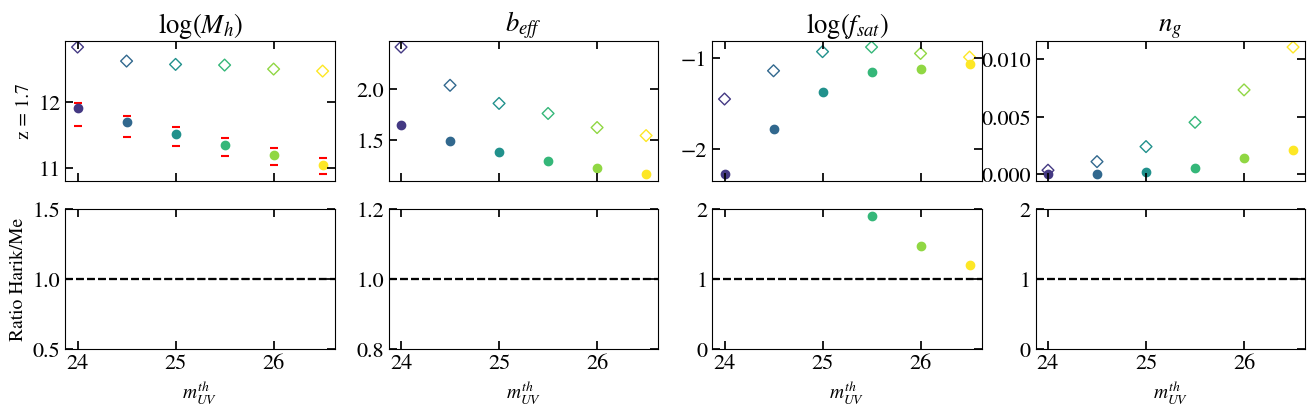

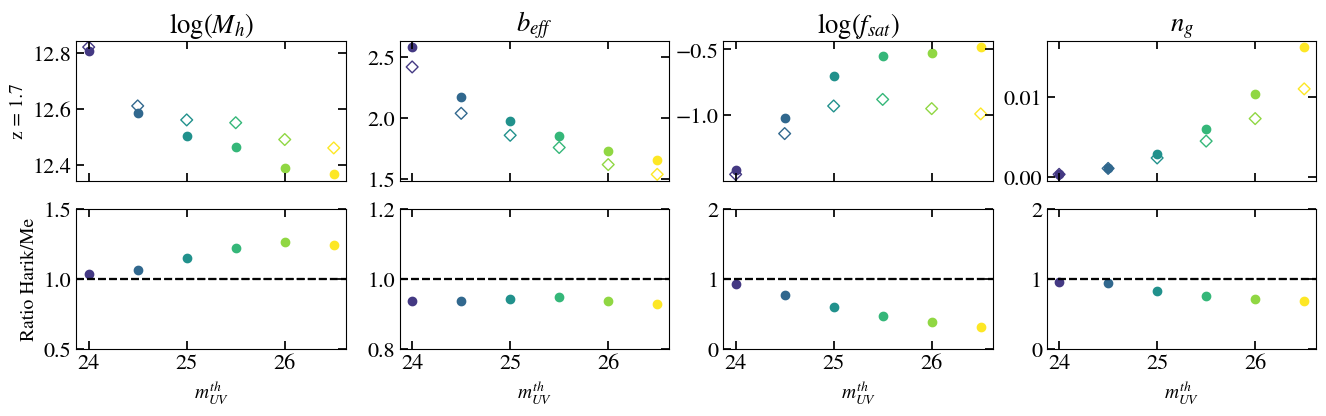

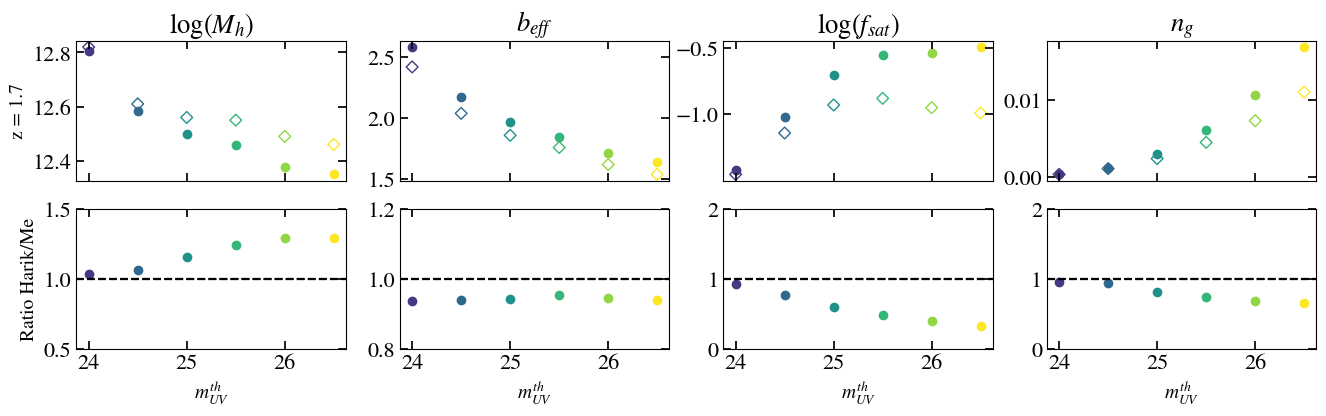

In [107]:
def plot_comparison_2(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g):
    fig, ax = plt.subplots(2,4, figsize=(16,4), sharex=True)
    m_array, i = np.arange(23.5, 27, 0.5), 0
    _col_ = iter(cm.viridis(np.linspace(0, 1, len(m_array))))
    for m in m_array:
        z_array, N_z_nrm = get_z_and_N_array(z, m, VERBOSE = False)
        _A_ , _B_ =  get_M_DM_range(z_analysis = z, m_max=m+0.25, m_min=m-0.25)
        _c_ = next(_col_)
        if z_array is not None:
            logMh, beff, logfsat, n_g = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                    M_sat_array[i], alpha,
                                                    z, z_array, N_z_nrm, AVG_OVER_Z = False ,
                                                    _A_ =np.power(10, _A_), _B_ = np.power(10, _B_))
            ax[0, 0].scatter(m, _A_, c= 'r', marker = "_")
            ax[0, 0].scatter(m, _B_, c= 'r', marker = "_")
            ax[0, 0].scatter(m, logMh, c= _c_)
            ax[0, 1].scatter(m, beff, c= _c_)
            ax[0, 2].scatter(m, logfsat, c= _c_)
            ax[0, 3].scatter(m, n_g, c= _c_)
            ax[0, 0].scatter(m, H_log_avg_Mh[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 1].scatter(m, H_beff[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 2].scatter(m, H_log_fsat[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 3].scatter(m, H_n_g[i], edgecolors= _c_, marker = 'D', facecolors='none')
            if 0 :
                logMh, beff, logfsat, n_g = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                        M_sat_array[i], alpha,
                                                        z, z_array, N_z_nrm,
                                                        AVG_OVER_Z = True)
                ax[0, 0].scatter(m, logMh, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 1].scatter(m, beff, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 2].scatter(m, logfsat, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 3].scatter(m, n_g, edgecolors= _c_, marker = 'o', facecolors='none')
            ax[1, 0].scatter(m, np.power(10, H_log_avg_Mh[i])/np.power(10, logMh), c= _c_)
            ax[1, 1].scatter(m, H_beff[i]/beff, c= _c_)
            ax[1, 2].scatter(m, np.power(10, H_log_fsat[i])/np.power(10, logfsat), c= _c_)
            ax[1, 3].scatter(m, H_n_g[i]/n_g, c= _c_)
            ax[1, 0].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 1].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 2].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 3].axhline(1, ls='--', c = 'k', alpha = 0.5)
            i += 1
    ax[0, 0].set_title(r'$\log(M_h)$')
    ax[0, 1].set_title(r'$b_{eff}$')
    ax[0, 2].set_title(r'$\log(f_{sat})$')
    ax[0, 3].set_title(r'$n_{g}$')
    ax[1, 0].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 1].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 2].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 3].set_xlabel(r'$m^{th}_{UV}$')
    ax[0, 0].set_ylabel(f'z = {z}')
    ax[1, 0].set_ylabel(f'Ratio Harik/Me')
    ax[1, 0].set_ylim((0.5, 1.5))
    ax[1, 1].set_ylim((0.8, 1.2))
    ax[1, 2].set_ylim((0, 2))
    ax[1, 3].set_ylim((0, 2))
    plt.show()

def plot_comparison_3(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g):
    fig, ax = plt.subplots(2,4, figsize=(16,4), sharex=True)
    m_array, i = np.arange(23.5, 27, 0.5), 0
    _col_ = iter(cm.viridis(np.linspace(0, 1, len(m_array))))
    for m in m_array:
        z_array, N_z_nrm = get_z_and_N_array(z, m, VERBOSE = False)
        _A_ , _B_ =  get_M_DM_range(z_analysis = z, m_max=m+0.25, m_min=m-0.25)
        _c_ = next(_col_)
        if z_array is not None:
            logMh, beff, logfsat, n_g = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                    M_sat_array[i], alpha,
                                                    z, z_array, N_z_nrm, AVG_OVER_Z = False ,
                                                    _A_ =np.power(10, _A_), _B_ = np.infty)
            #ax[0, 0].scatter(m, _A_, c= 'r', marker = "_")
            ax[0, 0].scatter(m, logMh, c= _c_)
            ax[0, 1].scatter(m, beff, c= _c_)
            ax[0, 2].scatter(m, logfsat, c= _c_)
            ax[0, 3].scatter(m, n_g, c= _c_)
            ax[0, 0].scatter(m, H_log_avg_Mh[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 1].scatter(m, H_beff[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 2].scatter(m, H_log_fsat[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 3].scatter(m, H_n_g[i], edgecolors= _c_, marker = 'D', facecolors='none')
            if 0 :
                logMh, beff, logfsat, n_g = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                        M_sat_array[i], alpha,
                                                        z, z_array, N_z_nrm,
                                                        AVG_OVER_Z = True)
                ax[0, 0].scatter(m, logMh, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 1].scatter(m, beff, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 2].scatter(m, logfsat, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 3].scatter(m, n_g, edgecolors= _c_, marker = 'o', facecolors='none')
            ax[1, 0].scatter(m, np.power(10, H_log_avg_Mh[i])/np.power(10, logMh), c= _c_)
            ax[1, 1].scatter(m, H_beff[i]/beff, c= _c_)
            ax[1, 2].scatter(m, np.power(10, H_log_fsat[i])/np.power(10, logfsat), c= _c_)
            ax[1, 3].scatter(m, H_n_g[i]/n_g, c= _c_)
            ax[1, 0].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 1].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 2].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 3].axhline(1, ls='--', c = 'k', alpha = 0.5)
            i += 1
    ax[0, 0].set_title(r'$\log(M_h)$')
    ax[0, 1].set_title(r'$b_{eff}$')
    ax[0, 2].set_title(r'$\log(f_{sat})$')
    ax[0, 3].set_title(r'$n_{g}$')
    ax[1, 0].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 1].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 2].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 3].set_xlabel(r'$m^{th}_{UV}$')
    ax[0, 0].set_ylabel(f'z = {z}')
    ax[1, 0].set_ylabel(f'Ratio Harik/Me')
    ax[1, 0].set_ylim((0.5, 1.5))
    ax[1, 1].set_ylim((0.8, 1.2))
    ax[1, 2].set_ylim((0, 2))
    ax[1, 3].set_ylim((0, 2))
    plt.show()

z= 1.7
log_M_min = np.array([12.46, 12.09, 11.79, 11.55, 11.33, 11.16])
log_M_sat = np.array([14.18, 13.47, 12.86, 12.48, 12.28, 12.08])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.82, 12.61, 12.56, 12.55, 12.49, 12.46])
H_beff       = np.array([2.42,   2.04,  1.86,  1.76,  1.62,  1.54])
H_log_fsat   = np.array([-1.45, -1.14, -0.93, -0.88, -0.95, -0.99])
H_n_g        = np.array([3.6e-4, 1.1e-3, 2.4e-3, 4.5e-3, 7.3e-3, 1.1e-2])
plot_comparison_2(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g)
plot_comparison_3(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g)
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat, H_n_g)


In [86]:
m_array, i = np.arange(23.5, 27, 0.5), 0
for m in m_array[:2]:
    _A_ , _B_ =  get_M_DM_range(z_analysis = 1.7, m_max=m+0.25, m_min=m-0.25)
    logMh, beff, logfsat, n_g = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                    M_sat_array[i], alpha,
                                                    z, z_array, N_z_nrm, AVG_OVER_Z = False ,
                                                    _A_ =np.power(10, _A_), _B_ = np.power(10, _B_))
    print(m)
    print('### m_min to m_max ###')
    print(f' logMh : {logMh:.2f}')
    print(f' beff : {beff:.2f}')
    print(f' logfsat : {logfsat:.2f}')
    print(f' n_g : {n_g:.2f}')
    logMh, beff, logfsat, n_g = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                    M_sat_array[i], alpha,
                                                    z, z_array, N_z_nrm, AVG_OVER_Z = False )
    m_mask = np.logical_and(M_h_array > np.power(10, _A_), M_h_array < np.power(10, _B_))
    NTOT = HOD.N_tot(M_h_array[m_mask], M_sat_array[i], alpha, M_min_array[i], sigma_logM)
    MA = np.trapz(M_h_array[m_mask]*HMF_array[m_mask]*NTOT, M_h_array[m_mask])/np.trapz(HMF_array[m_mask]*NTOT, M_h_array[m_mask])
    #print(MA)
    print()
    print('### 0 to infinity ###')
    print(f' logMh : {logMh:.2f}')
    print(f' beff : {beff:.2f}')
    print(f' logfsat : {logfsat:.2f}')
    print(f' n_g : {n_g:.2f}')
    m_mask = np.logical_and(M_h_array > 0, M_h_array < np.infty)
    NTOT = HOD.N_tot(M_h_array[m_mask], M_sat_array[i], alpha, M_min_array[i], sigma_logM)
    MB = np.trapz(M_h_array[m_mask]*HMF_array[m_mask]*NTOT, M_h_array[m_mask])/np.trapz(HMF_array[m_mask]*NTOT, M_h_array[m_mask])
    #print(MB)
    print(f' --> ratio {MA/MB:.2f}')

23.5
### m_min to m_max ###
 logMh : 12.09
 beff : 1.79
 logfsat : -2.10
 n_g : 0.00

### 0 to infinity ###
 logMh : 12.80
 beff : 2.58
 logfsat : -1.42
 n_g : 0.00
 --> ratio 0.19
24.0
### m_min to m_max ###
 logMh : 11.91
 beff : 1.64
 logfsat : -2.28
 n_g : 0.00

### 0 to infinity ###
 logMh : 12.80
 beff : 2.58
 logfsat : -1.42
 n_g : 0.00
 --> ratio 0.13
